# Metis Data Science Bootcamp
## San Francisco, Winter 2020
### Project 4: Election Reporting Sentiment Analysis

### Topic Modeling

In [4]:
import sys
import re
import os.path
import requests
import time
import pandas as pd
import numpy as np

from os import path

from pymongo import MongoClient

In [5]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import spacy
from spacy import displacy
from pprint import pprint
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

import re
import string

from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")

In [6]:
from gensim.models import LdaModel

In [7]:
db_client = MongoClient()
db_news = db_client['news_search']
db_news_col = db_news['search_result']

In [8]:
db_news_content = db_news['news_content']
cursor = db_news_content.find({}, {'_id':0, 'name': 1, 'text': 1, 'url' : 1, 'base_url' : 1, 'pub_date': 1})

In [9]:
cursor = db_news_content.find({}, {'_id':0, 'name': 1, 'text': 1, 'url' : 1, 'base_url' : 1, 'pub_date': 1})
print(len(list(cursor)))

3795


In [10]:
db_news_content = db_news['news_content']



In [11]:
cursor = db_news_content.find({}, {'_id':1, 'text': 1, 'short_text' : 1 , 'prop_nouns' : 1})
articles = list(cursor)
X_nouns = []
X_what = []
y = []
for article in articles :
    X_what.append(article['short_text'])
    y.append(article['_id'])

In [12]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

## Start with Count Vectorizing

In [13]:
# build our corpus
corpus = []
cursor = db_news_content.find({}, {'_id':1, 'text': 1, 'short_text' : 1, 'prop_nouns' : 1})
for article in list(cursor) :
    corpus.append(article['short_text'])


In [14]:
vectorizer = CountVectorizer(stop_words='english', max_df=1.5, max_features=80, ngram_range=(1,2))
cv = vectorizer.fit(corpus)

X_cv_what = cv.transform(X_what)
X_cv_what_df = pd.DataFrame(X_cv_what.toarray(), columns=vectorizer.get_feature_names())


## Vectorize with TF-IDF

In [15]:
tf_vect = TfidfVectorizer(stop_words='english', max_df=1.5, max_features=80, ngram_range=(1,2))
tfidf = tf_vect.fit(corpus)

X_tf_what = tfidf.transform(X_what)
X_tf_what_df = pd.DataFrame(X_cv_what.toarray(), columns=vectorizer.get_feature_names())


## LDA
Prep some values for later visualization

In [16]:
sum_words = X_cv_what.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq[:300], key = lambda x: x[1], reverse=True)
top_words = [word[0].upper() for word in words_freq]

In [17]:
lda_model = LatentDirichletAllocation(n_components=8,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

lda_output = lda_model.fit_transform(X_cv_what)

In [33]:
print_top_words(lda_model, vectorizer.get_feature_names(), 5)

Topic #0: debate steyer bloomberg billionaire million
Topic #1: biden voter poll sander hampshire
Topic #2: caucus iowa result delegate sander
Topic #3: iowa buttigieg people event year
Topic #4: buttigieg klobuchar black debate hampshire
Topic #5: sander biden trump democrats year
Topic #6: bloomberg trump york people city
Topic #7: warren woman sander plan debate



In [34]:

import sklearn
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
ldavizdata = pyLDAvis.sklearn.prepare(lda_model, X_cv_what, cv, mds='tsne')
pyLDAvis.save_html(ldavizdata, 'pyLDA_Full_Corpus.html')

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [35]:
# Using the output above we can name the topics
topic_what_labels = ['Sanders Trump', 'People', 'Biden', 'Bloomberg',\
                     'Iowa Caucus Result', 'Buttigieg', 'Voter Steyer', 'Warren']

## Truncated Singular Value Decomposition

In [36]:
lsa_cv = TruncatedSVD(15)
X_cv_topic_what = lsa_cv.fit_transform(X_cv_what)

sum(lsa_cv.explained_variance_ratio_)

0.7629901953932308

In [37]:
# Put the article ID back into the dataframe so we can keep the data together in sorts.
X_lda = pd.DataFrame(lda_output)
X_lda['_id'] = y

X_lda.head()

,0,1,2,3,4,5,6,7,_id
0,0.003686,0.003679,0.141323,0.003685,0.003682,0.267660,0.402518,0.173766,5e4d93b4bdc708691b5225e0
1,0.006587,0.006591,0.006594,0.006588,0.006585,0.313239,0.647229,0.006588,5e4d93b5bdc708691b5225e1
2,0.002407,0.002406,0.002406,0.002409,0.002405,0.575374,0.410186,0.002407,5e4d93b5bdc708691b5225e2
3,0.273301,0.563376,0.154377,0.001788,0.001789,0.001789,0.001790,0.001789,5e4d93b5bdc708691b5225e3
4,0.062533,0.062514,0.062509,0.562062,0.062526,0.062569,0.062677,0.062611,5e4d93b6bdc708691b5225e4


In [38]:
# Sort a specific column and look at the results
X_sorted = X_lda.sort_values(2, ascending=False)
X_sorted.head(100)

,0,1,2,3,4,5,6,7,_id
264,0.001097,0.001098,0.992313,0.001099,0.001098,0.001098,0.001098,0.001098,5e4d97ec76d86711581f107c
622,0.001147,0.001148,0.991963,0.001148,0.001148,0.001148,0.001148,0.001148,5e4d9bcd76d86711581f11e2
66,0.001147,0.001148,0.991963,0.001148,0.001148,0.001148,0.001148,0.001148,5e4d941dbdc708691b522622
374,0.001238,0.001240,0.991325,0.001239,0.001239,0.001239,0.001239,0.001239,5e4d98ae76d86711581f10ea
3592,0.001304,0.001304,0.990868,0.001305,0.001304,0.001305,0.001305,0.001304,5e549593aa3ffc14697ac14f
...,...,...,...,...,...,...,...,...,...
3182,0.001646,0.001646,0.751336,0.123591,0.001647,0.116838,0.001648,0.001647,5e549322aa3ffc14697abfb4
2254,0.000934,0.136505,0.748786,0.110039,0.000934,0.000935,0.000934,0.000934,5e4f4bc669e593627678417c
2455,0.033379,0.000778,0.747258,0.215474,0.000777,0.000778,0.000778,0.000778,5e4f4ceb69e5936276784245
1970,0.013896,0.183534,0.733070,0.013901,0.013902,0.013906,0.013895,0.013897,5e4ebaac071f29602ba1ba8e


In [39]:
db_news_content.delete_many({'base_url' : 'www.wacotrib.com'})
cursor = db_news_content.find({}, {'_id':1, 'base_url':1, 'text': 1, 'short_text' : 1 })
len(list(cursor))

3795

In [40]:
cursor = db_news_content.find({}, {'_id':1, 'base_url':1, 'text': 1, 'short_text' : 1})

# find the sentiment associated with each topic
def topic_sentiment_check(df, topic_id, num_arts) :
    
    # Check that the topic specified is in the topic space
    if not topic_id in df.columns:
        print('Bad topic ID. %d not in topic space' % topic_id)
        return
    # Sort the values for the specified topic.
    X_sorted = df.sort_values(topic_id, ascending=False)
    X_sorted = X_sorted.reset_index(drop=True)
    
    subjectivity_list = []
    polarity_list = []  
    
    # For the requested number of articles
    for x in X_sorted.index[:num_arts] :

        cursor = db_news_content.find({'_id': X_sorted.loc[x,'_id']} , {'url': 1, 'sentiment':1})
        arts = list(cursor)
        for article in arts :
            polarity = article['sentiment'][0]
            polarity_list.append(polarity)
            
            subjectivity_list.append(article['sentiment'][1])
      
    return np.mean(polarity_list), np.var(polarity_list), np.mean(subjectivity_list), np.var(subjectivity_list)

In [54]:
topic_what_sents = []
topic_noun_sents = []

for topic in X_lda.columns[:-1] :
    topic_what_sents.append([topic, topic_sentiment_check(X_lda, topic, 100)])
    

In [55]:
import matplotlib.pyplot as plt

In [56]:
topics_what = [topic_what_sents[x][0] for x in range(len(topic_what_sents))]
topic_what_polarities = [topic_what_sents[x][1][0] for x in range(len(topic_what_sents))]
topic_what_polarities_var = [topic_what_sents[x][1][1] for x in range(len(topic_what_sents))]
topic_what_subjectivities = [topic_what_sents[x][1][2] for x in range(len(topic_what_sents))]
topic_what_subjectivities_var = [topic_what_sents[x][1][3] for x in range(len(topic_what_sents))]

topics_noun = [topic_noun_sents[x][0] for x in range(len(topic_noun_sents))]
topic_noun_polarities = [topic_noun_sents[x][1][0] for x in range(len(topic_noun_sents))]
topic_noun_polarities_var = [topic_noun_sents[x][1][1] for x in range(len(topic_noun_sents))]
topic_noun_subjectivities = [topic_noun_sents[x][1][2] for x in range(len(topic_noun_sents))]
topic_noun_subjectivities_var = [topic_noun_sents[x][1][3] for x in range(len(topic_noun_sents))]


In [57]:
topics_what


[0, 1, 2, 3, 4, 5, 6, 7]

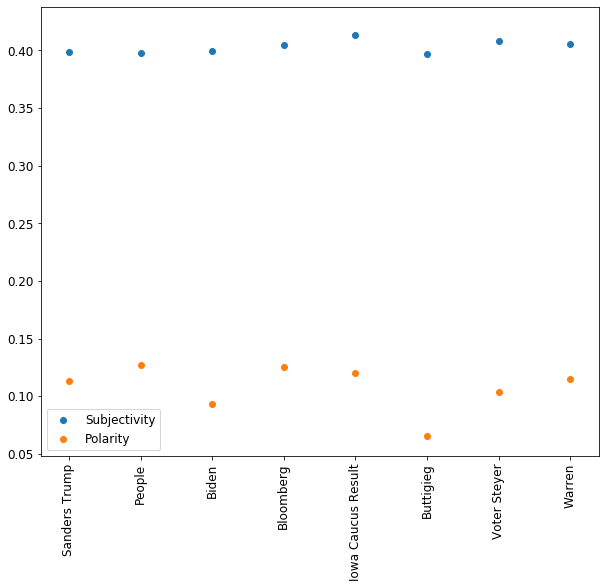

In [58]:
width = 0.35  # the width of the bars
nptopics = np.array(topics_what)

#fig, ax = plt.subplots(figsize=[10,8])
fig = plt.figure(figsize=[10,8])
#ax.set_xticks(nptopics)
plt.xticks(nptopics, topic_what_labels, rotation=90)

#rects1 = ax.bar(nptopics-width/2, topic_what_subjectivities, width, label='Subjectivity')
#rects2 = ax.bar(nptopics+width/2, topic_what_polarities, width, label='Polarity')

plt.scatter(nptopics, topic_what_subjectivities, label='Subjectivity')
plt.scatter(nptopics, topic_what_polarities,  label='Polarity')

#plt.xlabel(topic_what_labels, rotation=45)
plt.legend()

plt.show()

In [59]:
nptopics

array([0, 1, 2, 3, 4, 5, 6, 7])

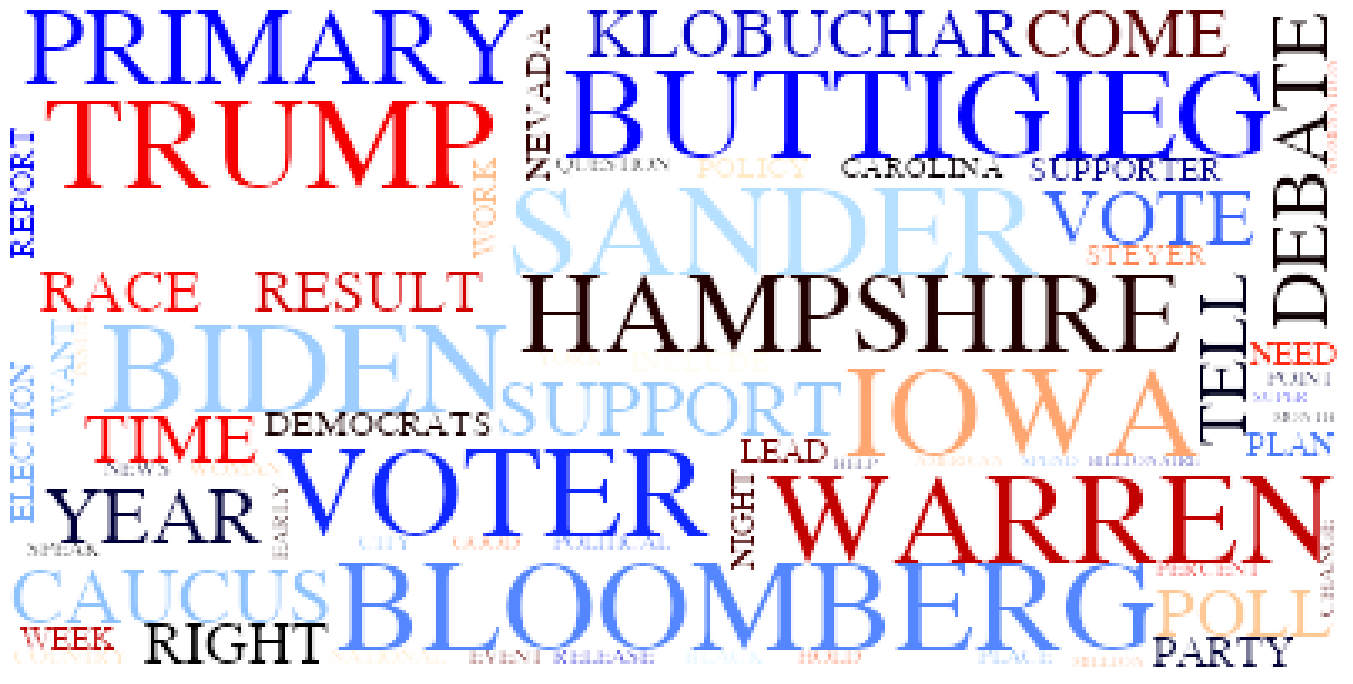

In [105]:
from IPython import display
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

fig.patch.set_alpha(0.)


mpl.rcParams['figure.figsize']=(24,16)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=800             
mpl.rcParams['figure.subplot.bottom']=.1

stopwords = set(STOPWORDS)

fig = plt.figure(1)
plt.axis('off')

word_string = ' '.join(top_words)

display.clear_output(wait=True)
wordcloud = WordCloud(
        background_color="rgba(255, 255, 255, 0)", mode="RGBA",
        font_path='/System/Library/Fonts/Times.ttc',
        stopwords=stopwords,
        max_words=70,
        max_font_size=40, 
        random_state=101,
        colormap='flag'
        ).generate(word_string)

wordcloud.to_file('word_cloud_5.png')
plt.imshow(wordcloud)

#plt.savefig('word_cloud_5.png', Transparent=True)
#display.display(fig)

## KMeans Clustering

In [61]:
word_string

'SANDER BIDEN BUTTIGIEG WARREN IOWA TRUMP BLOOMBERG VOTER HAMPSHIRE PEOPLE PRIMARY SUPPORT CAUCUS DEBATE VOTE YEAR KLOBUCHAR TIME POLL JUST COME TELL RIGHT RACE RESULT PARTY DEMOCRATS NEVADA SUPPORTER ELECTION WORK WEEK LEAD NEED PLAN WANT REPORT NIGHT POLICY INCLUDE CAROLINA STEYER DELEGATE POLITICAL BLACK WOMAN EVENT CITY POINT GOOD PERCENT NEWS SPEAK PLACE QUESTION CHANGE YORK COUNTRY NATIONAL ISSUE EARLY RELEASE HOLD BILLIONAIRE MILLION HELP SPEND SUPER MONTH NOMINATION AMERICAN COMMENT ACCORD THING HEALTH MONEY CARE MIKE NUMBER SECOND'

## Word 2 Vec

In [16]:
settings = {
    'window_size': 2,    # context window +- center word
    'n': 10,    # dimensions of word embeddings, also refer to size of hidden layer
    'epochs': 50,    # number of training epochs
    'learning_rate': 0.01   # learning rate

}

In [17]:
all_words = []

for token in corpus :
        all_words.extend(token.split())
len(all_words)

1335202

In [18]:
all_words[0]

'washington'

In [19]:
'warren' in all_words

True

In [20]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/gensim/corpora/dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict
/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:73: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import namedtuple, defaultdict, Iterable


## Explore Using Word2Vec

In [21]:
# Initialise object
model = Word2Vec([all_words], size=100, window=20, min_count=10, workers=4)

In [22]:
model.train([all_words], total_examples=model.corpus_count, epochs=model.epochs)

(50000, 6676010)

In [24]:
model.similar_by_word('buttigieg')

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('voter', 0.9999606609344482),
 ('poll', 0.9999600648880005),
 ('primary', 0.9999524354934692),
 ('lead', 0.9999514818191528),
 ('biden', 0.9999514222145081),
 ('over', 0.9999508261680603),
 ('last', 0.9999470710754395),
 ('support', 0.9999456405639648),
 ('among', 0.9999423027038574),
 ('bloomberg', 0.9999420642852783)]

In [44]:
# Numpy ndarray with one-hot representation for [target_word, context_words]
#training_data = model.train(corpus, total_examples=1, epochs=10)

In [54]:
import gensim.downloader as api

#word_vectors = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [56]:
#result = word_vectors.similar_by_word("warren")
#print("{}: {:.4f}".format(*result[0]))

harrison: 0.7126
